## Решение домашнего задания к уроку 5. Рекуррентные нейронные сети

Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2023-07-24 08:23:52--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 108.177.98.113, 108.177.98.101, 108.177.98.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.98.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/42sn8sigsavmbqe8gg3q72fka8tc7abr/1690187025000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=34eaec5b-808f-4cd5-9ae4-f5e1c127a5cd [following]
--2023-07-24 08:23:52--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/42sn8sigsavmbqe8gg3q72fka8tc7abr/1690187025000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=34eaec5b-808f-4cd5-9ae4-f5e1c127a5cd
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 142.250.107.132, 2607

In [5]:
airline_passengers_data = pd.read_csv('/content/airline-passengers.csv')

In [6]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [9]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [10]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [12]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [13]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [14]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [15]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [16]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [17]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [18]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

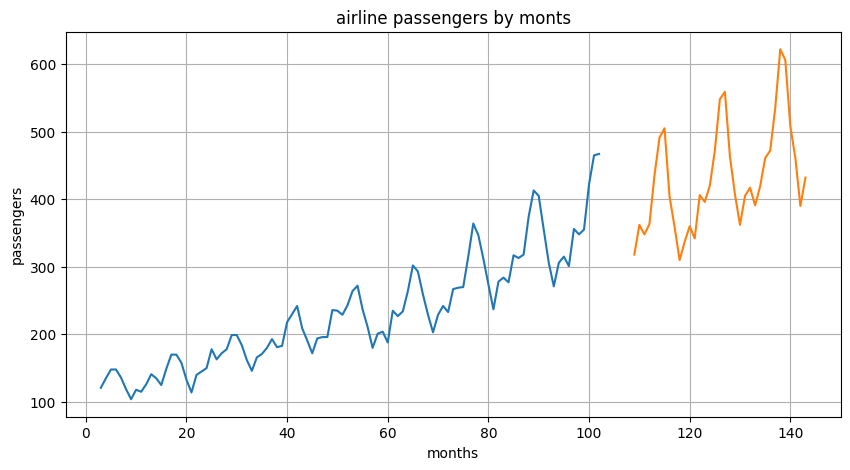

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [21]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [22]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [23]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [24]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [25]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 15s 45ms/step - loss: 57024.5352 - mae: 226.1247 - val_loss: 195224.3438 - val_mae: 434.5331
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56581.2031 - mae: 225.1971 - val_loss: 193626.3750 - val_mae: 432.7292
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 56403.2148 - mae: 225.0340 - val_loss: 192193.0156 - val_mae: 431.1130
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 56107.0977 - mae: 224.6356 - val_loss: 189926.4844 - val_mae: 428.5483
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 55371.1875 - mae: 223.4977 - val_loss: 184756.9531 - val_mae: 422.6256
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 53293.4648 - mae: 220.0468 - val_loss: 171717.7500 - val_mae: 407.2415
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 47492.5664 - mae: 209.4448 - val_loss: 141109.9375 - val_mae: 

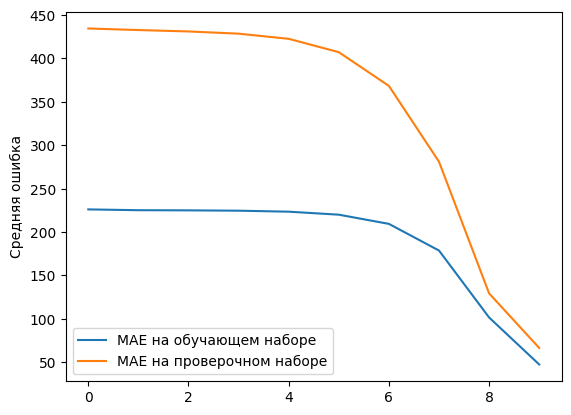

In [26]:
plt.plot(history_1.history['mae'][:],
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:],
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [28]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 1789.9014 - mae: 34.3484 - val_loss: 15738.9170 - val_mae: 105.5336
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 1146.2623 - mae: 26.3782 - val_loss: 14559.1299 - val_mae: 100.3274
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 1147.5183 - mae: 26.7966 - val_loss: 11619.2500 - val_mae: 86.0445
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 1142.6715 - mae: 26.5038 - val_loss: 12097.5557 - val_mae: 89.1212
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 1059.8303 - mae: 25.7122 - val_loss: 12072.7627 - val_mae: 89.3598
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1035.3383 - mae: 25.3757 - val_loss: 11459.0537 - val_mae: 86.3636
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 1007.2068 - mae: 24.9794 - val_loss: 11224.7090 - val_mae: 85.3474
Epoch 8/10
13/13 [

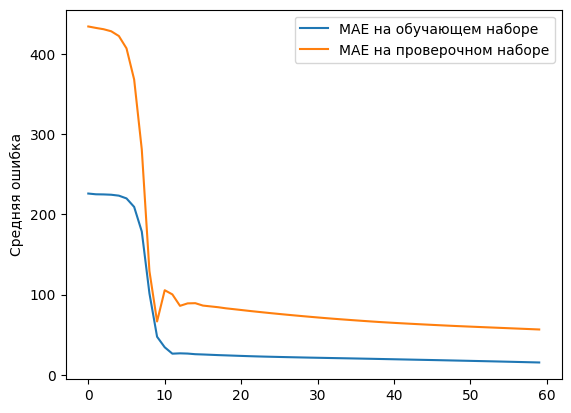

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 380.1591 - mae: 15.1498 - val_loss: 5419.4785 - val_mae: 56.1592
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 369.9842 - mae: 14.9064 - val_loss: 5351.3740 - val_mae: 55.7582
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 359.8878 - mae: 14.6592 - val_loss: 5283.5039 - val_mae: 55.3536
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 349.8731 - mae: 14.4060 - val_loss: 5215.8203 - val_mae: 54.9452
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 339.9442 - mae: 14.1656 - val_loss: 5148.2964 - val_mae: 54.5326
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 330.1053 - mae: 13.9296 - val_loss: 5080.9131 - val_mae: 54.1155
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 320.3615 - mae: 13.6925 - val_loss: 5013.6519 - val_mae: 53.6939
Epoch 8/10
13/13 [================

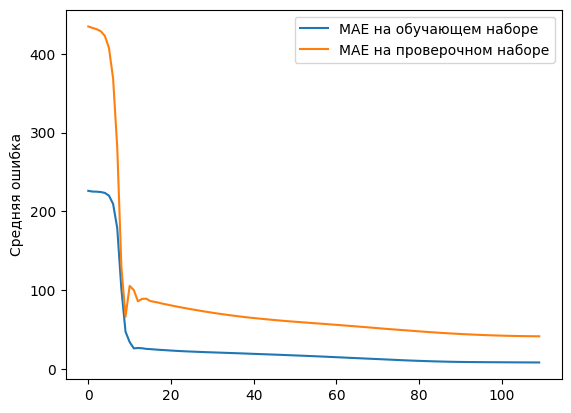

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 118.8310 - mae: 8.4298 - val_loss: 3144.2185 - val_mae: 41.6174
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 117.8166 - mae: 8.4015 - val_loss: 3148.4644 - val_mae: 41.6434
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 117.0745 - mae: 8.3681 - val_loss: 3134.3394 - val_mae: 41.5377
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 115.9274 - mae: 8.3366 - val_loss: 3150.8875 - val_mae: 41.6487
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 115.4132 - mae: 8.2993 - val_loss: 3122.1147 - val_mae: 41.4553
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 113.9308 - mae: 8.2670 - val_loss: 3169.3093 - val_mae: 41.7652
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 114.1732 - mae: 8.2398 - val_loss: 3093.2234 - val_mae: 41.2732
Epoch 8/10
13/13 [=======================

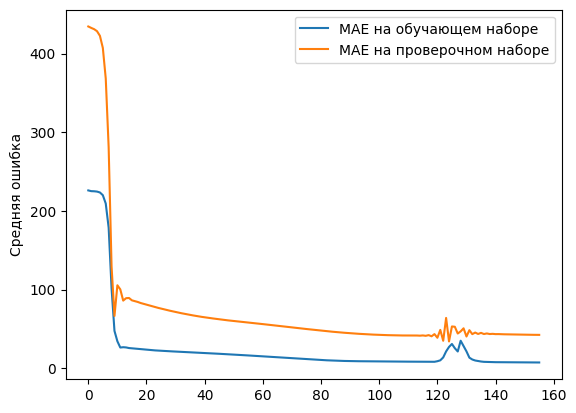

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 96.1633 - mae: 7.3558 - val_loss: 3221.3325 - val_mae: 42.4492
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 95.7792 - mae: 7.3369 - val_loss: 3219.0283 - val_mae: 42.4300
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 95.3909 - mae: 7.3164 - val_loss: 3216.8003 - val_mae: 42.4132
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 95.0048 - mae: 7.2963 - val_loss: 3215.3191 - val_mae: 42.4002
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 94.6434 - mae: 7.2790 - val_loss: 3214.3640 - val_mae: 42.3919
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 94.2650 - mae: 7.2575 - val_loss: 3213.6191 - val_mae: 42.3853
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 93.9161 - mae: 7.2402 - val_loss: 3213.8577 - val_mae: 42.3849
Epoch 8/10
13/13 [==============================

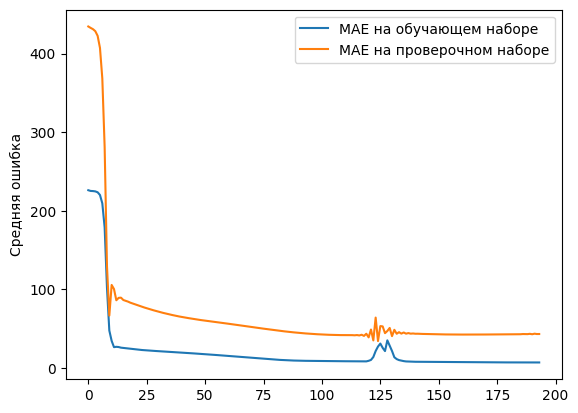

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 87.6143 - mae: 6.9435 - val_loss: 3420.7622 - val_mae: 43.8667
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 90.0839 - mae: 7.0978 - val_loss: 3230.9631 - val_mae: 42.4547
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 87.8870 - mae: 6.9937 - val_loss: 3488.2004 - val_mae: 44.4499
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 88.8273 - mae: 7.0252 - val_loss: 3273.7305 - val_mae: 42.7106
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 87.2796 - mae: 6.9300 - val_loss: 3363.8726 - val_mae: 43.6141
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 91.8647 - mae: 7.2873 - val_loss: 3514.6479 - val_mae: 44.4943
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 102.7504 - mae: 7.8174 - val_loss: 3114.9424 - val_mae: 41.5681
Epoch 8/10
13/13 [=============================

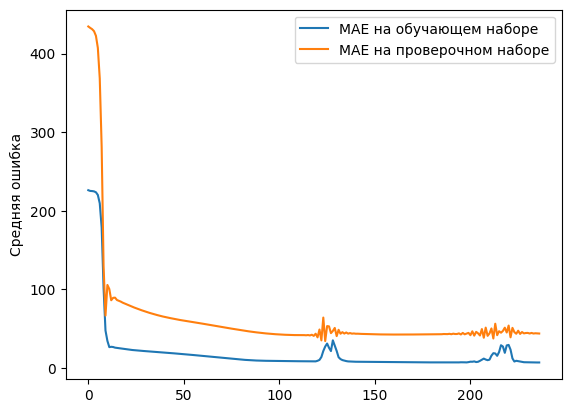

In [29]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1,
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1,
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [30]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 3ms/step


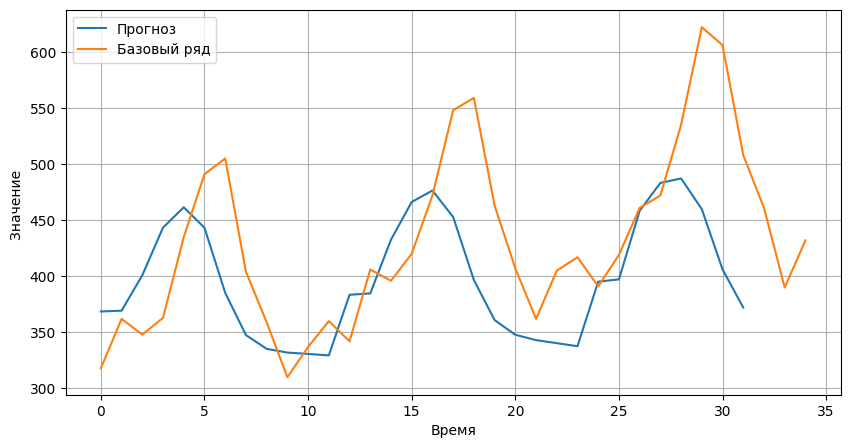

In [31]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

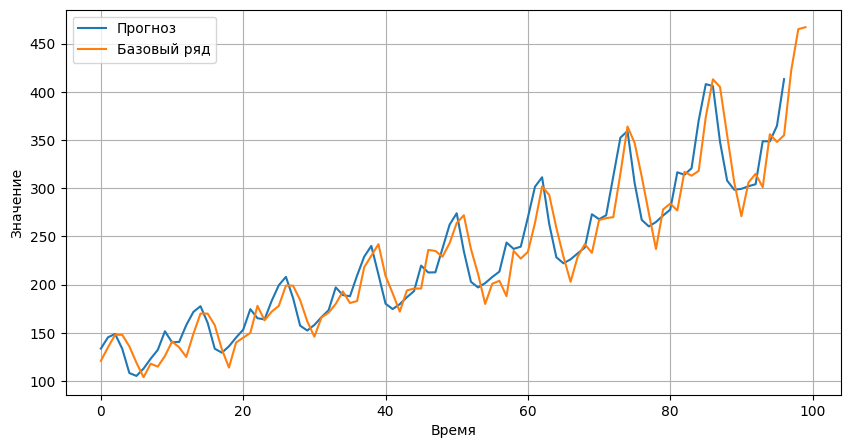

In [32]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [33]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 4ms/step - loss: 3353.9087 - mae: 43.6959
train_loss: 79.93942260742188, train_m: 6.708107948303223
test_loss: 3353.90869140625, test_m: 43.695919036865234


**LSTM**

In [34]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [35]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 7s 128ms/step - loss: 56663.2461 - mae: 225.6427 - val_loss: 193162.3125 - val_mae: 432.1832
Epoch 2/10
13/13 [==============================] - 0s 21ms/step - loss: 56382.6445 - mae: 225.0443 - val_loss: 192358.2031 - val_mae: 431.2550
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 55666.1367 - mae: 223.5876 - val_loss: 189905.5938 - val_mae: 428.4221
Epoch 4/10
13/13 [==============================] - 0s 21ms/step - loss: 53125.9297 - mae: 218.4026 - val_loss: 180434.0469 - val_mae: 417.3469
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 44430.9883 - mae: 199.8129 - val_loss: 146439.7656 - val_mae: 375.0673
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 21200.7754 - mae: 138.0793 - val_loss: 58731.4648 - val_mae: 233.1810
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 1082.3997 - mae: 25.6309 - val_loss: 4898.2822 - val_mae: 52.59

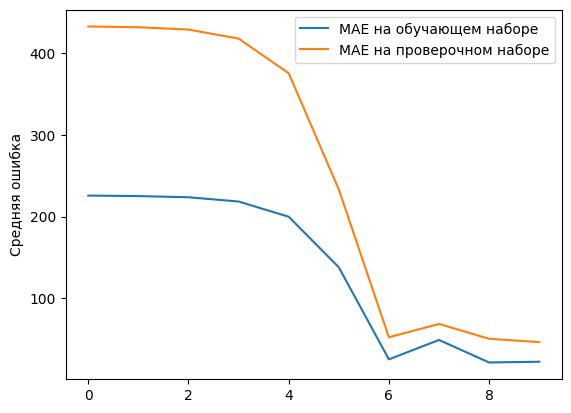

In [36]:
plt.plot(history_2.history['mae'][:],
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:],
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [37]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [38]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 692.8909 - mae: 20.6367 - val_loss: 4637.4258 - val_mae: 49.5452
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 688.4585 - mae: 20.6753 - val_loss: 4193.5571 - val_mae: 47.5728
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 663.5728 - mae: 19.8550 - val_loss: 4363.7275 - val_mae: 48.2468
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 659.1342 - mae: 19.8620 - val_loss: 4204.9170 - val_mae: 47.4697
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 655.5175 - mae: 19.8044 - val_loss: 4141.9546 - val_mae: 47.1161
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 651.1505 - mae: 19.7612 - val_loss: 4070.3167 - val_mae: 46.7186
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 648.0741 - mae: 19.7288 - val_loss: 4003.7529 - val_mae: 46.3848
Epoch 8/10
13/13 [================

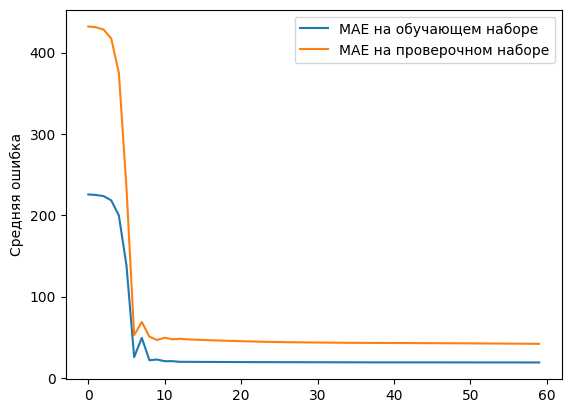

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 584.5906 - mae: 19.0502 - val_loss: 2994.0635 - val_mae: 41.9222
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 583.2147 - mae: 19.0345 - val_loss: 2981.2791 - val_mae: 41.8498
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 581.7994 - mae: 19.0177 - val_loss: 2968.4299 - val_mae: 41.7750
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 580.3418 - mae: 18.9995 - val_loss: 2955.5100 - val_mae: 41.6976
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 578.8391 - mae: 18.9845 - val_loss: 2942.5073 - val_mae: 41.6177
Epoch 6/10
13/13 [==============================] - 0s 16ms/step - loss: 577.2876 - mae: 18.9699 - val_loss: 2929.4136 - val_mae: 41.5350
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 575.6840 - mae: 18.9539 - val_loss: 2916.2209 - val_mae: 41.4495
Epoch 8/10
13/13 [================

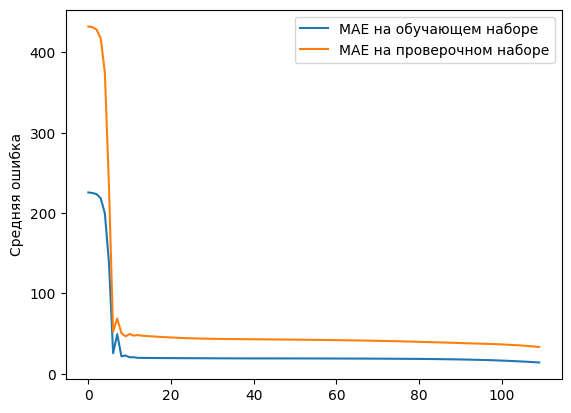

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 293.6808 - mae: 13.7927 - val_loss: 1706.8801 - val_mae: 32.8485
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 277.7601 - mae: 13.4362 - val_loss: 1642.3042 - val_mae: 32.3364
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 262.0336 - mae: 13.0683 - val_loss: 1577.2782 - val_mae: 31.7895
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 246.7512 - mae: 12.7009 - val_loss: 1512.7209 - val_mae: 31.2409
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 232.1686 - mae: 12.3245 - val_loss: 1449.6427 - val_mae: 30.7168
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 218.5276 - mae: 11.9458 - val_loss: 1389.0811 - val_mae: 30.2256
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 206.0349 - mae: 11.5717 - val_loss: 1332.0150 - val_mae: 29.7084
Epoch 8/10
13/13 [================

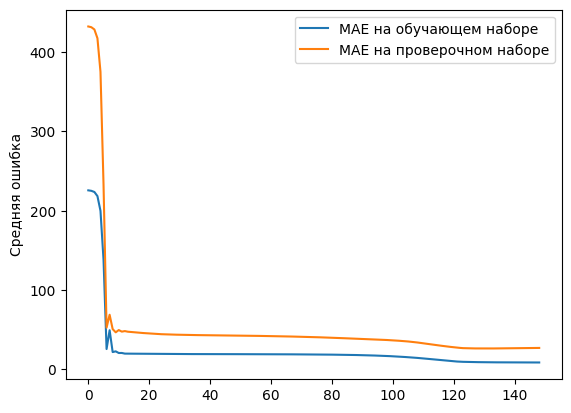

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 130.1626 - mae: 8.6769 - val_loss: 1011.3461 - val_mae: 27.0554
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 129.8016 - mae: 8.6680 - val_loss: 1013.9791 - val_mae: 27.0891
Epoch 3/10
13/13 [==============================] - 0s 16ms/step - loss: 129.4560 - mae: 8.6614 - val_loss: 1016.7907 - val_mae: 27.1225
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 129.1273 - mae: 8.6559 - val_loss: 1019.7571 - val_mae: 27.1552
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 128.8146 - mae: 8.6504 - val_loss: 1022.8177 - val_mae: 27.1865
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 128.5153 - mae: 8.6459 - val_loss: 1025.8962 - val_mae: 27.2160
Epoch 1/10
13/13 [==============================] - 0s 17ms/step - loss: 128.2257 - mae: 8.6409 - val_loss: 1028.9833 - val_mae: 27.2442
Epoch 2/10
13/13 [=======================

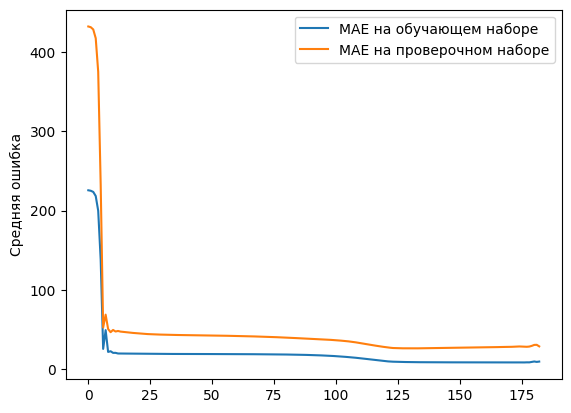

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 238.2702 - mae: 11.9529 - val_loss: 1023.0806 - val_mae: 26.9460
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 236.6205 - mae: 12.7477 - val_loss: 1130.9099 - val_mae: 27.8834
Epoch 3/10
13/13 [==============================] - 0s 17ms/step - loss: 264.7154 - mae: 12.8501 - val_loss: 1462.4679 - val_mae: 32.9174
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 577.5532 - mae: 19.1385 - val_loss: 2711.8389 - val_mae: 47.2446
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 383.6877 - mae: 16.2133 - val_loss: 1401.9252 - val_mae: 32.9482
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 799.3734 - mae: 24.1672 - val_loss: 897.9512 - val_mae: 23.7589
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 600.5779 - mae: 20.4824 - val_loss: 1776.3600 - val_mae: 35.7524
Epoch 8/10
13/13 [=================

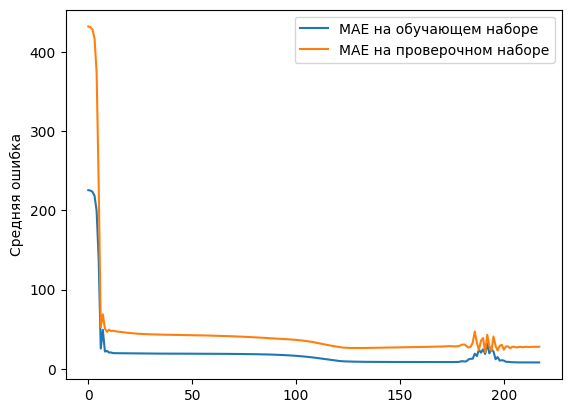

In [39]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2,
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2,
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [40]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 6ms/step


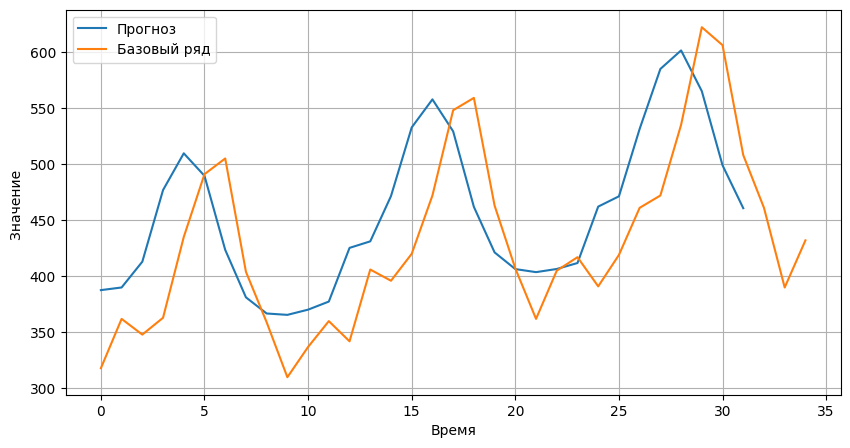

In [41]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

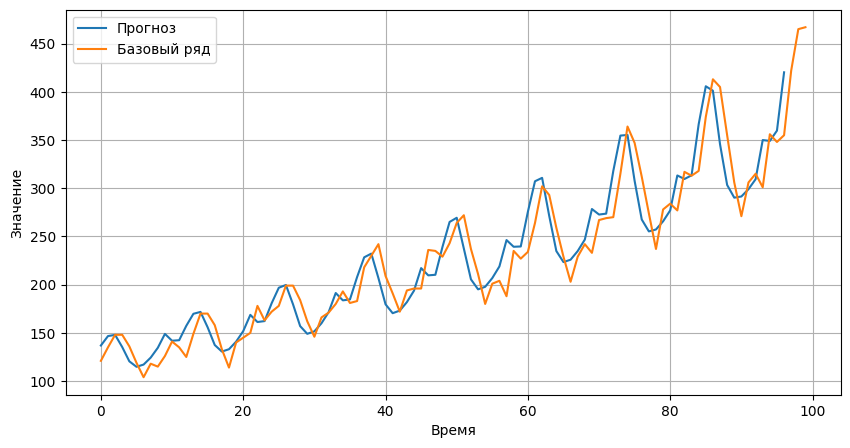

In [42]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [43]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 5ms/step - loss: 1089.8580 - mae: 27.9864
train_loss: 99.6244888305664, train_m: 7.6207075119018555
test_loss: 1089.8580322265625, test_m: 27.98635482788086


**Выводы: **<br>
* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился GRU, хотя LSTM сравним с ним по качеству